__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Polygon

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data.pkl'

In [6]:
# df = pd.read_pickle(data_file)
# df['priceMU'] = df['priceM']/df['area']

# area_bins = [ 0., 1., 2., 4., 8., 20., 1e6, ]
# labels =    [ '<1', '1-2','2-4', '4-8', '8-20', '20+' ]
# df['area_size_category'] = pd.cut( df['area'], bins = area_bins, labels=labels)

# df= df.drop(columns=['area_cut'])

# df.to_pickle(data_file)
# df[['title','adr','area','area_size_category','price','priceM','priceMU']]

In [7]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

1077


title                                  adr  latitude  \
989  Участок 5,6 сот. (ИЖС)           Балаклава, ул. Калича, 61А     44.50   
694  Участок 9,3 сот. (ИЖС)  ТИЗ Гранит, 2-й Альпийский пер., 10       NaN   
899    Участок 8 сот. (ИЖС)          с. Орлиное, ул. Пушкина, 17     44.44   

     longitude  priceM                      ts  
989      33.60   29.00 2022-09-08 16:04:40.227  
694        NaN   10.10 2022-09-08 16:04:40.227  
899      33.77    3.00 2022-09-08 16:04:40.227

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077 entries, 0 to 1076
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   avito_id            1077 non-null   int64         
 1   title               1077 non-null   object        
 2   price               1077 non-null   int64         
 3   obj_name            1077 non-null   object        
 4   adr                 1077 non-null   object        
 5   description         1077 non-null   object        
 6   avito_page          1077 non-null   int64         
 7   ts                  1077 non-null   datetime64[ns]
 8   area                1077 non-null   float64       
 9   is_IJS              1077 non-null   bool          
 10  priceM              1077 non-null   float64       
 11  latitude            585 non-null    float64       
 12  longitude           585 non-null    float64       
 13  priceMU             1077 non-null   float64     

In [9]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

1077
585


In [10]:
# # берём самые свежие объявления
# print(len(df))
# df = df[ (df['ts']==df['ts'].max()) ].reset_index(drop=True)
# print(len(df))

In [11]:
# cols = ['title','adr','latitude','longitude','priceM']
# df[cols]

### ограничиваем тип объекта 

In [12]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('is_IJS')
# df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))

585
585


In [13]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

title                             adr  latitude  \
327    Участок 4 сот. (ИЖС)             Монастырское ш., 10     44.55   
395    Участок 8 сот. (ИЖС)  Балаклава, Фонтанный пер., 28А     44.51   
134  Участок 8,2 сот. (ИЖС)          район Северная Сторона     44.63   

     longitude  priceM  
327      33.53    4.00  
395      33.60    3.40  
134      33.55    1.40

In [14]:
del df

## общая статистика изменение цены

In [15]:
ts = '2022-08-01' # ограничиваем дату

In [16]:
stat = gdf.groupby(['dt','area_size_category'])['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
stat

count  mean   std  min  10%   25%   50%   75%  \
dt         area_size_category                                                  
2022-09-08 <1                   2.00  7.66 10.38 0.32 1.78  3.99  7.66 11.33   
           1-2                  2.00  1.45  0.64 1.00 1.09  1.23  1.45  1.67   
           2-4                 68.00  3.90  2.33 0.00 1.70  2.19  3.30  5.65   
           4-8                279.00  4.97  4.10 0.00 1.80  2.50  3.50  6.05   
           8-20               209.00  7.03  7.87 0.32 2.00  3.00  4.50  7.50   
           20+                 25.00 32.26 27.45 1.10 8.50 14.00 26.00 37.00   

                                90%    max  
dt         area_size_category               
2022-09-08 <1                 13.53  15.00  
           1-2                 1.81   1.90  
           2-4                 7.10  11.70  
           4-8                 9.84  29.00  
           8-20               14.10  60.00  
           20+                69.20 120.00

<AxesSubplot:>

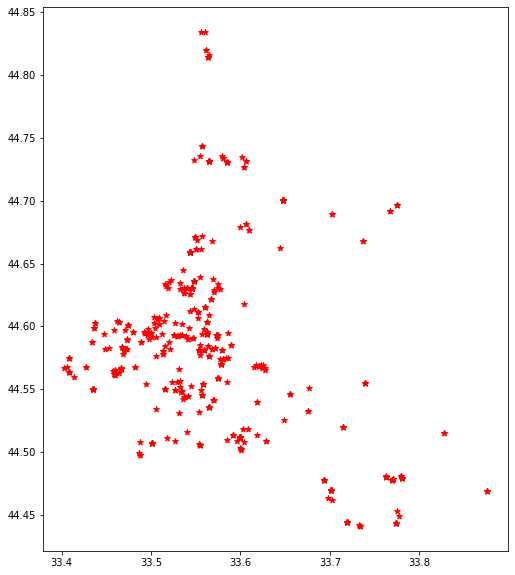

In [22]:
gdf[ gdf['ts']>ts ].plot(figsize=(10,10), color='r',marker='*')

In [23]:
# ctx.add_basemap(
#     gdf[ gdf['ts']>ts ].plot(figsize=(21,21), color='r',marker='*'), 
#     crs=gdf.crs, 
#     zoom=16,
#     # source=ctx.providers.Stamen.TonerLite,
#     source=ctx.providers.OpenStreetMap.Mapnik,
# )

## ограничиваем по район поиска

In [24]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')
# frames_index

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames['area_id'] = range(len(frames))

frames

area_name  \
0     Севастополь, район Острякова   
1  Севастополь, парк 60-летия СССР   
2  Севастополь, Хрусталёва/Хрюкина   
3  Севастополь, Геловани/Коломийца   
4     Севастополь, Музыки/Бирюзова   
5            Севастополь, кр.горка   

                                                                                                                                                                                geometry  \
0  POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))   
1                                                           POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))   
2                     POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))   
3                     POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))   
4                                                           POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))   
5  POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))   

   area_id  
0        0  
1        1  
2        2  
3        3  
4        4  
5        5

<AxesSubplot:>

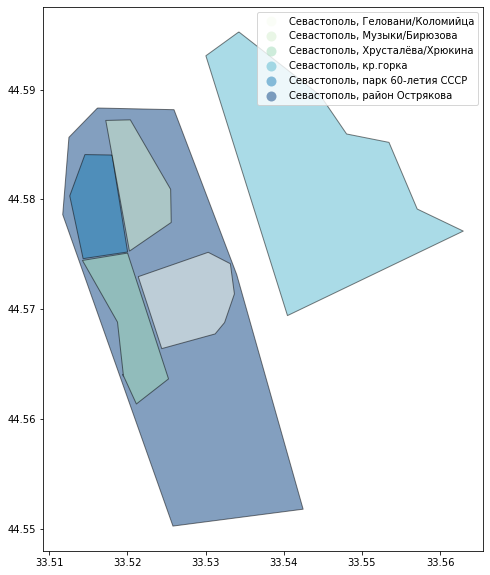

In [25]:
frames.plot('area_name', legend=True, cmap='GnBu', alpha=.5, edgecolor='k',figsize=(10,10),)  

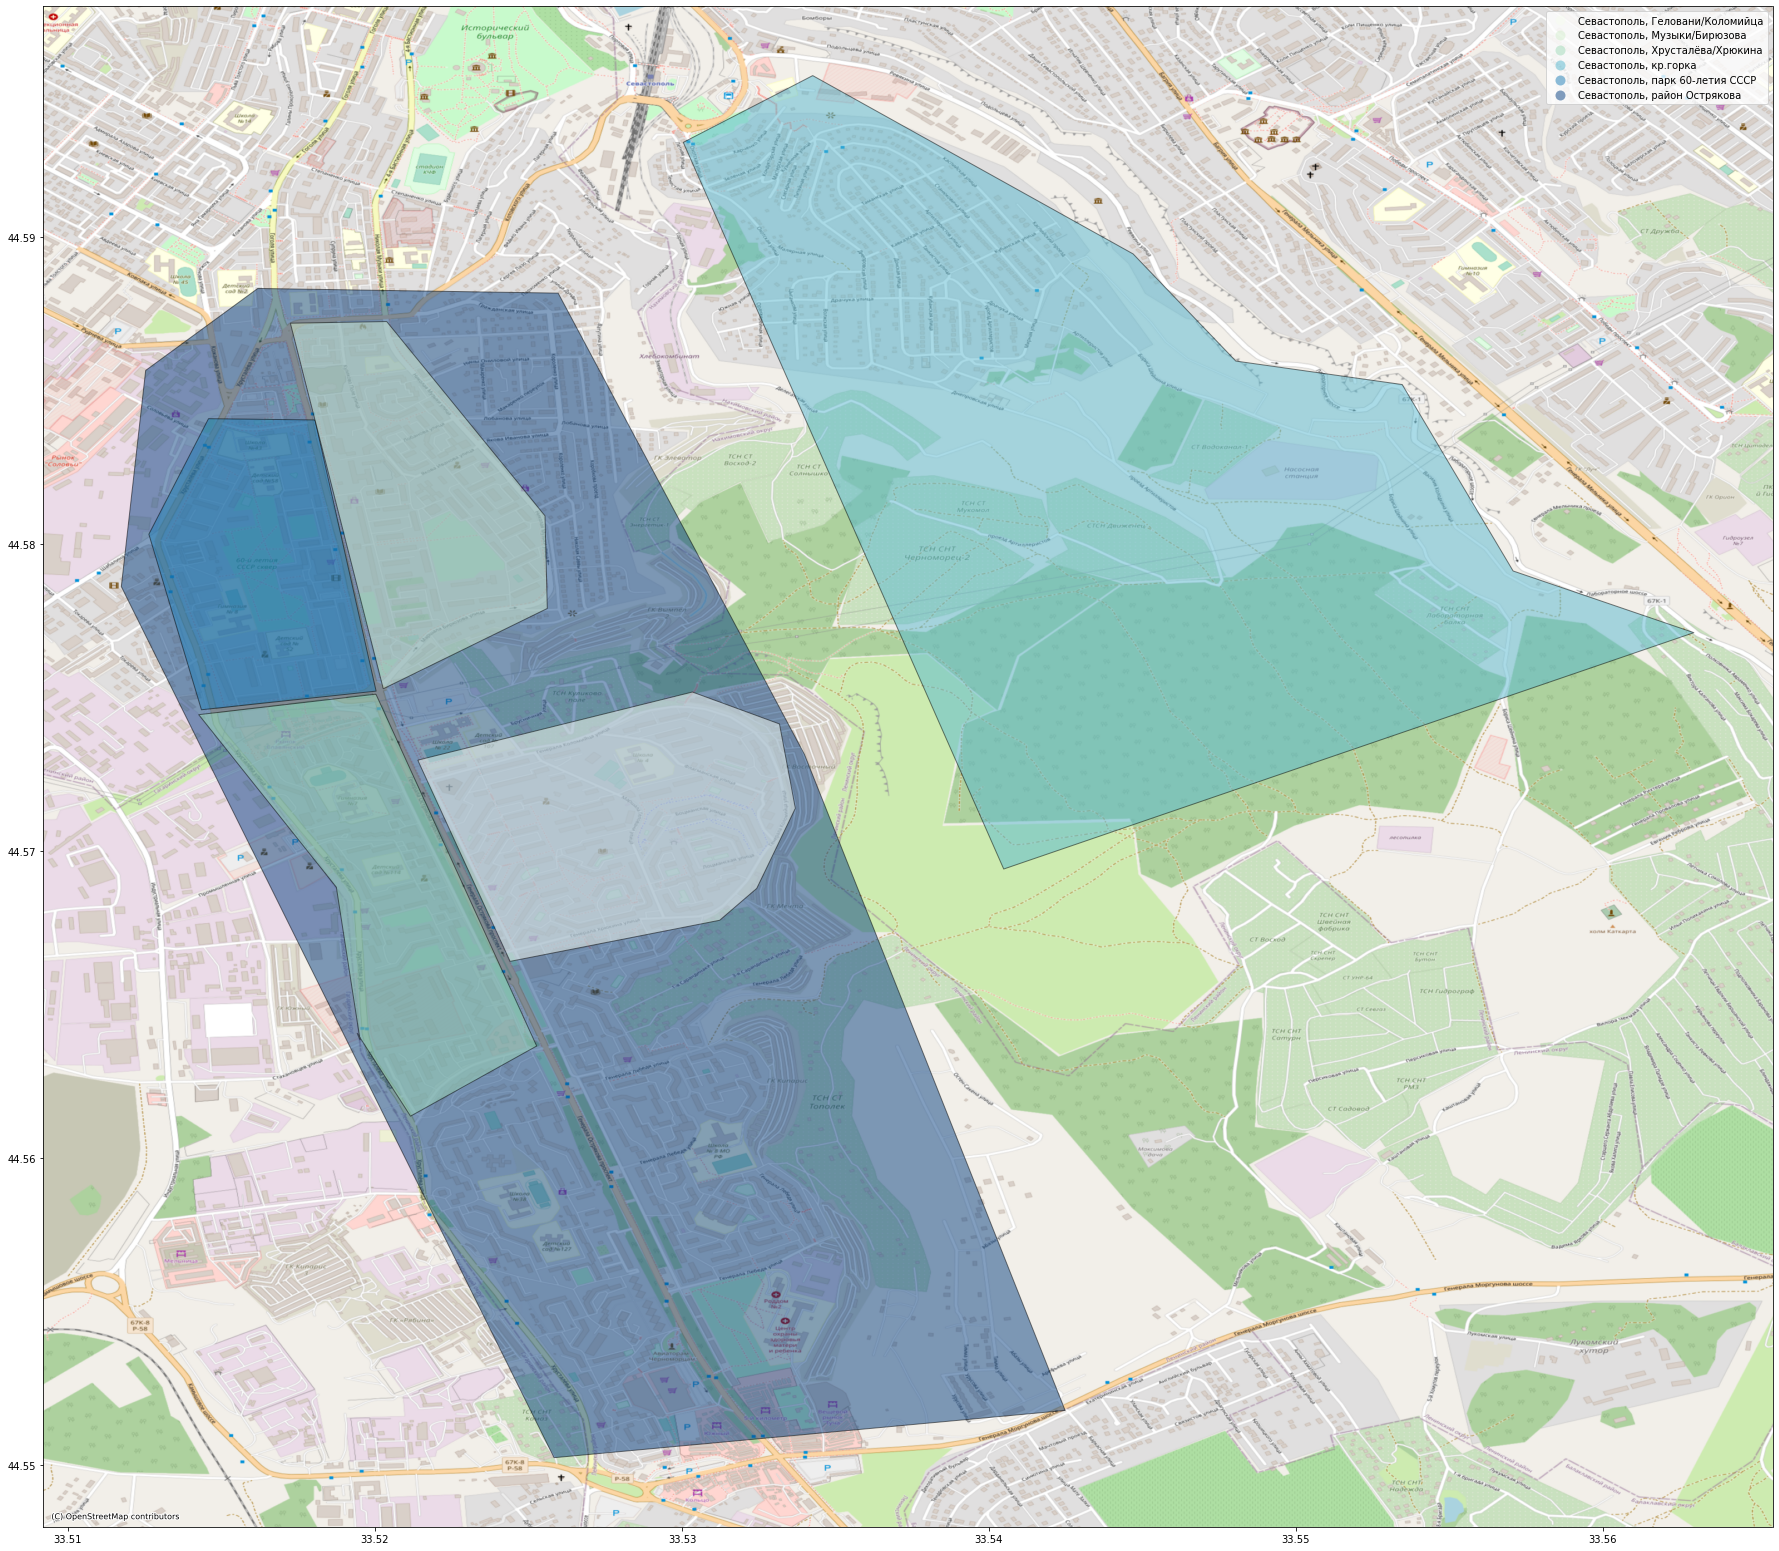

In [30]:
ctx.add_basemap(
    frames.plot('area_name',legend=True,cmap='GnBu',figsize=(31,31),alpha=.5,edgecolor='k'), 
    crs=gdf.crs, 
    zoom=16,
    source=ctx.providers.OpenStreetMap.Mapnik,
)

In [27]:
# фильтруем по области
print(len(gdf))
gdf_in_frame = gdf.sjoin( frames.query('area_id in (5,)'), how='inner', predicate='within') 
print(len(gdf_in_frame))

585
14


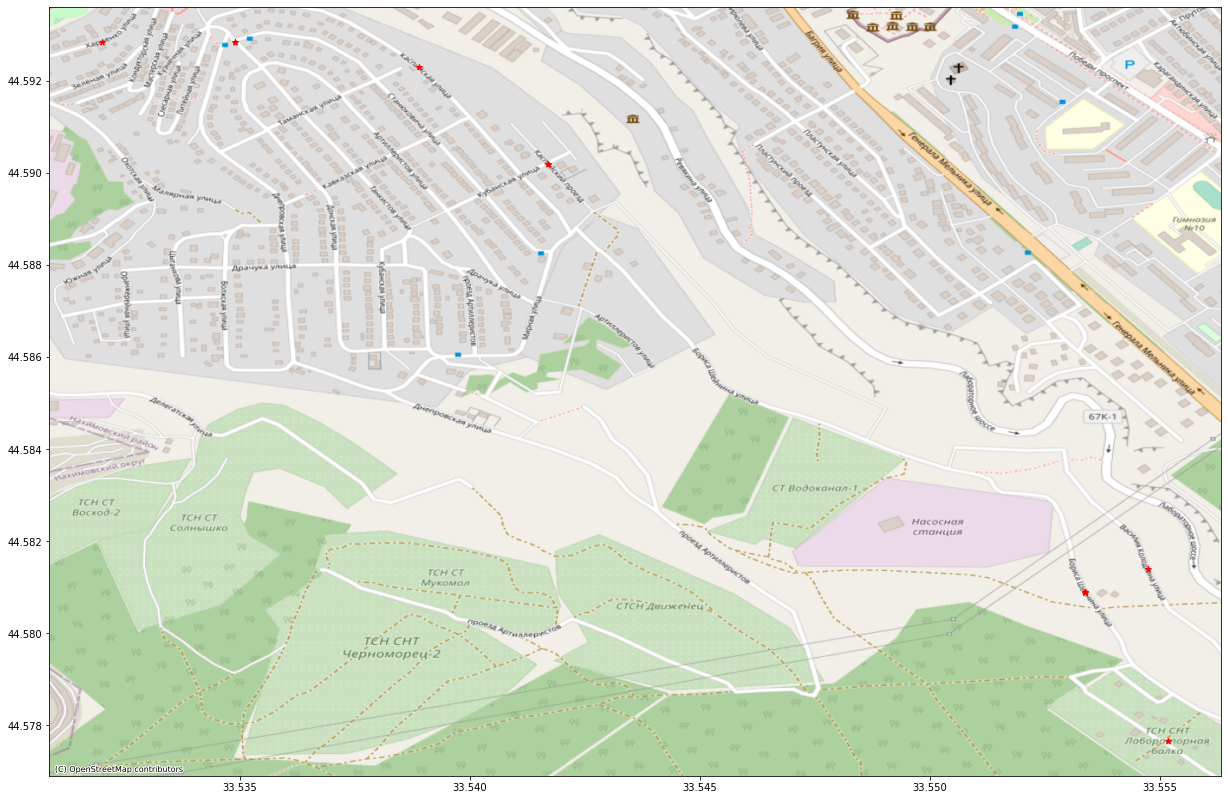

In [28]:
ctx.add_basemap(
    gdf_in_frame[ (gdf_in_frame['dt']==gdf_in_frame['dt'].max()) ]
      .plot(figsize=(21,21), color='r',marker='*'), 
    crs=gdf.crs, 
    zoom=16,
    # source=ctx.providers.Stamen.TonerLite,
    source=ctx.providers.OpenStreetMap.Mapnik,
)

### изменение цены

In [29]:
stat = gdf_in_frame.groupby(['dt','area_size_category'])['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
stat

count  mean  std  min  10%  25%  50%   75%  \
dt         area_size_category                                               
2022-09-08 2-4                  1.00  2.70  NaN 2.70 2.70 2.70 2.70  2.70   
           4-8                  9.00  4.88 2.79 2.20 2.44 2.65 2.80  8.00   
           8-20                 4.00  9.30 6.44 2.50 3.49 4.97 8.85 13.18   

                                90%   max  
dt         area_size_category              
2022-09-08 2-4                 2.70  2.70  
           4-8                 8.10  8.50  
           8-20               15.47 17.00

## гексагональная сетка

In [ ]:
import h3
    
def cover_grid_hexagonal(gmtr,cell_size=9,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame(
        { 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },
        crs=crs, 
    )

grid = cover_grid_hexagonal( frames.query('area_id in (5,)').geometry.values[0] )
print(len(grid))
grid.sample(2)

In [ ]:
ctx.add_basemap( 
    grid.plot(alpha=.5,color='yellow',edgecolors='blue',figsize=(31,31),), 
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs=grid.crs, 
    zoom=16,
)

### медиана актуальной цены

In [ ]:
grid_values = grid.sjoin(
        gdf[ gdf['dt']>ts ],
        how='inner',
    ).groupby(['hex_id'])['priceM'].median().reset_index()

len(grid_values)

ax = grid.merge(grid_values).plot(
    'priceM', 
    alpha=.5,
    edgecolors='blue',
    cmap='rainbow',
    figsize=(31,31), 
    legend=True, 
)

ax.set(title='медиана цены (в млн.руб.)')

ctx.add_basemap( 
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs=grid.crs, 
    zoom=16,
)

### количество предложений

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {  return false; }

In [ ]:
# количество предложений
from folium import Map
from folium.plugins import HeatMap

start_pos = (44.578330, 33.516509)

Map(
    location=start_pos,
    zoom_start=15,
    # width=500,
    #height=2000,
).add_child( 
    HeatMap( 
        gdf[ gdf['dt']>ts ]
        .sjoin(frames.query('area_id in (5,)'),how='inner',predicate='within')
        [['latitude','longitude',]],
        #radius=10.,
        #min_opacity=3. 
    )
)
